In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.callbacks import ModelCheckpoint

In [34]:
def load_data(img_dir, mask_dir, img_size=(256, 256)):
    images = []
    masks = []

    for img_file in os.listdir(img_dir):
        img_path = os.path.join(img_dir, img_file)
        mask_path = os.path.join(mask_dir, img_file.replace('.jpg', '.jpg'))

        img = load_img(img_path, target_size=img_size)
        mask = load_img(mask_path, target_size=img_size, color_mode="grayscale")

        img = img_to_array(img) / 255.0
        mask = img_to_array(mask).astype(np.uint8)  # Ensure mask is uint8

        # Downsample mask to reduce memory usage
        mask = cv2.resize(mask, img_size, interpolation=cv2.INTER_NEAREST)

        images.append(img)
        masks.append(mask)

    return np.array(images), np.array(masks)

img_dir = '/content/drive/MyDrive/data/images'
mask_dir = '/content/drive/MyDrive/data/masks'
img_size = (256, 256)  # Example size, adjust as necessary

images, masks = load_data(img_dir, mask_dir, img_size)

# Split Data
X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)

In [35]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate

def unet_model(input_size=(256, 256, 3), num_classes=255):  # Adjust num_classes based on your max label value
    inputs = Input(input_size)

    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)

    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=-1)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(up6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=-1)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(up7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=-1)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(up8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=-1)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(up9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)

    conv10 = Conv2D(num_classes, 1, activation='softmax')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    return model

In [36]:
model = unet_model(input_size=(img_size[0], img_size[1], 3), num_classes=255)  # Adjust num_classes based on your max label value

In [37]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [38]:
# Setup Model Checkpoint to save the best model
model_save_path = 'path/to/save/best_model.h5'  # Specify your path here
checkpoint = ModelCheckpoint(model_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')


In [41]:
# Train the Model
history = model.fit(X_train, y_train, epochs=50, batch_size=8, validation_data=(X_val, y_val), callbacks=[checkpoint])

Epoch 1/50
40/40 [==============================] - ETA: 0s - loss: 1.2335 - accuracy: 0.6825
Epoch 1: val_loss improved from 1.66353 to 1.26252, saving model to path/to/save/best_model.h5
40/40 [==============================] - 27s 683ms/step - loss: 1.2335 - accuracy: 0.6825 - val_loss: 1.2625 - val_accuracy: 0.7264
Epoch 2/50
40/40 [==============================] - ETA: 0s - loss: 1.2016 - accuracy: 0.6971
Epoch 2: val_loss improved from 1.26252 to 1.15866, saving model to path/to/save/best_model.h5
40/40 [==============================] - 33s 842ms/step - loss: 1.2016 - accuracy: 0.6971 - val_loss: 1.1587 - val_accuracy: 0.7528
Epoch 3/50
40/40 [==============================] - ETA: 0s - loss: 1.0936 - accuracy: 0.7124
Epoch 3: val_loss improved from 1.15866 to 1.08538, saving model to path/to/save/best_model.h5
40/40 [==============================] - 31s 771ms/step - loss: 1.0936 - accuracy: 0.7124 - val_loss: 1.0854 - val_accuracy: 0.7526
Epoch 4/50
40/40 [===================

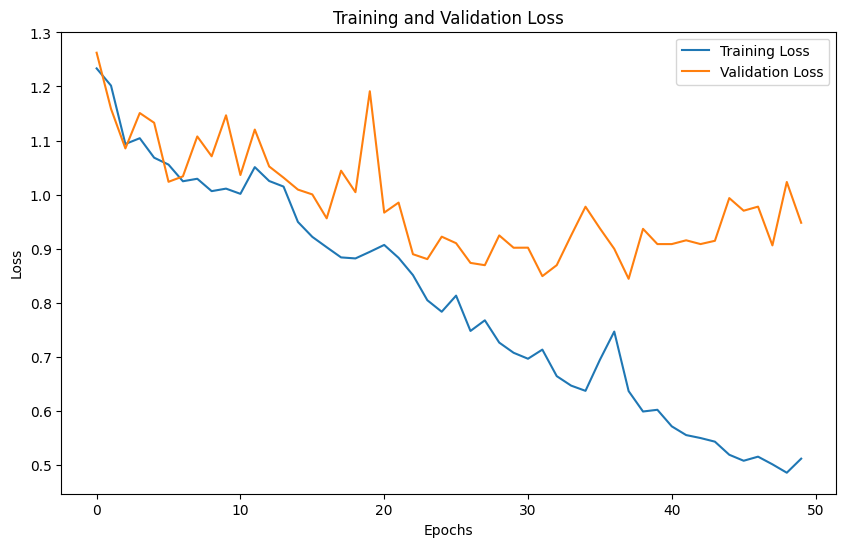

In [43]:
# Plot training and validation loss curves
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

1/1 [==============================] - 0s 277ms/step


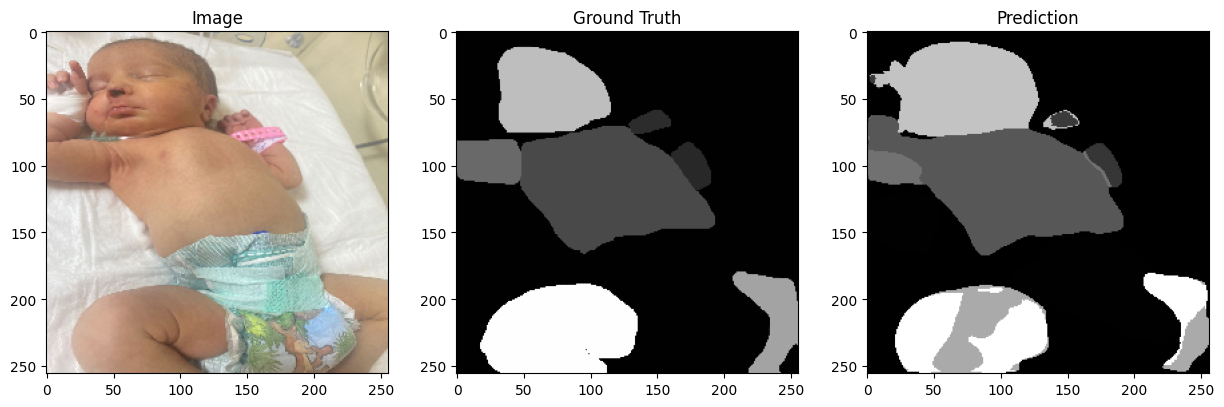

1/1 [==============================] - 0s 35ms/step


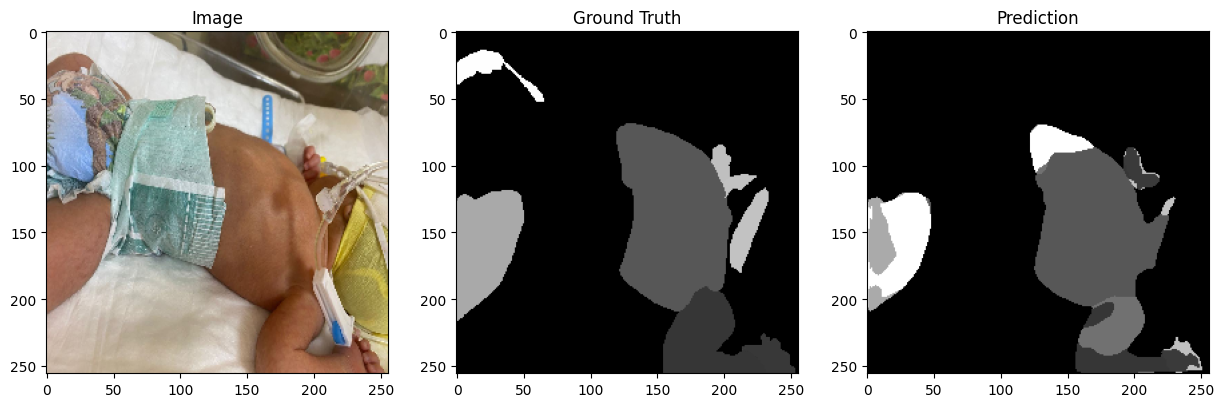

1/1 [==============================] - 0s 34ms/step


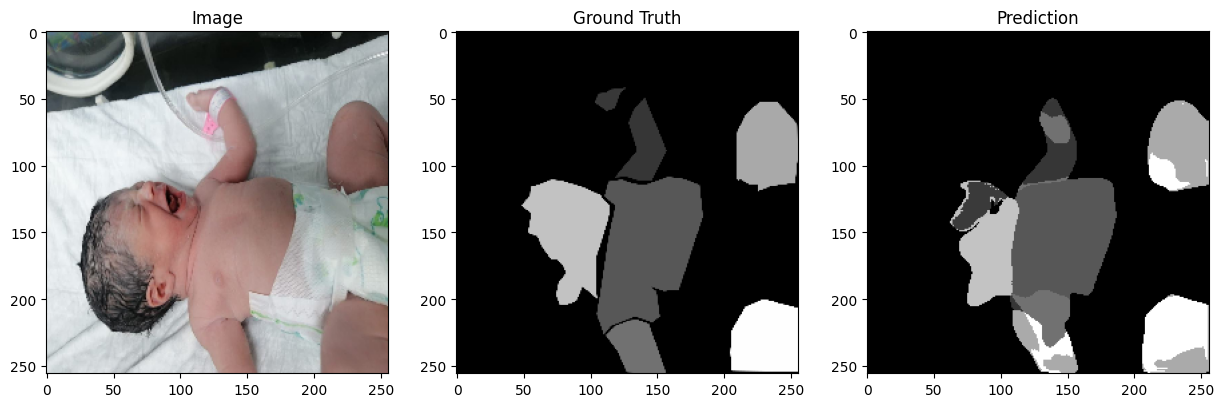

1/1 [==============================] - 0s 22ms/step


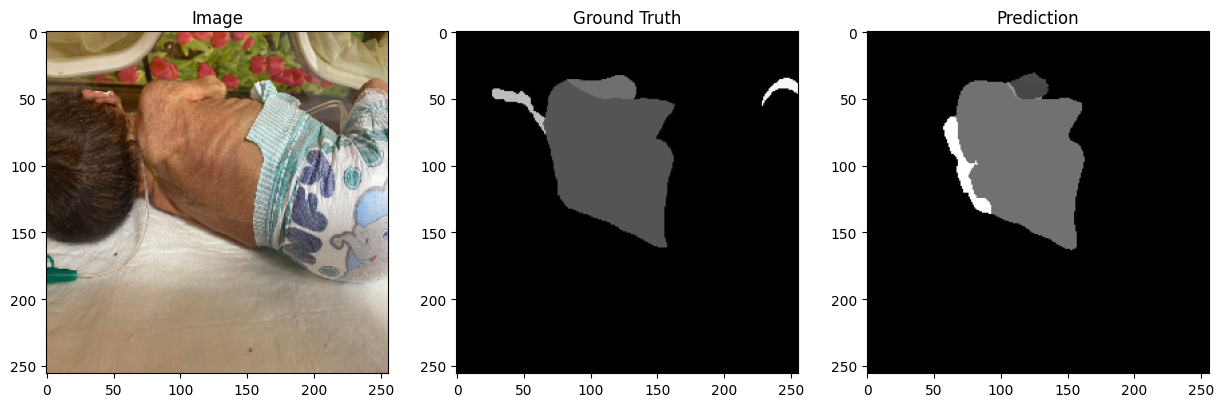

1/1 [==============================] - 0s 30ms/step


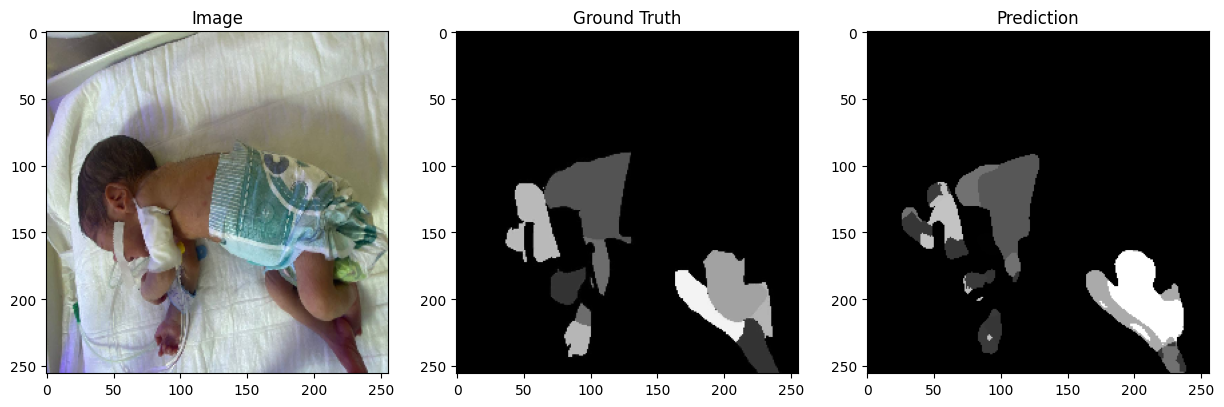

In [44]:
def visualize_predictions(model, images, masks, num_images=5):
    for i in range(num_images):
        idx = np.random.randint(0, len(images))
        image = images[idx]
        mask = masks[idx]
        prediction = model.predict(np.expand_dims(image, axis=0))[0]

        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        ax[0].imshow(image)
        ax[0].set_title('Image')
        ax[1].imshow(mask.squeeze(), cmap='gray')
        ax[1].set_title('Ground Truth')
        ax[2].imshow(np.argmax(prediction, axis=-1), cmap='gray')
        ax[2].set_title('Prediction')
        plt.show()

visualize_predictions(model, X_val, y_val)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved to Saved_model/model.h5
